In [1]:
import torch, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import griddata

import sys, os
sys.path.append(os.path.abspath("../../.."))
from Forward.mag3D import mag3D_8091
from Forward.utils import get_B0_and_m, compute_kernel

In [2]:
model_npz = np.load("../../../models/Toy1/Toy1.npz")


model = model_npz["suscep"]
cell_centers = model_npz["cell_centers"]    # (nx, ny, nz), bool
dx = model_npz["dx"]                      # (nx, ny, nz)
dy = model_npz["dy"]                      # (nx, ny, nz)
dz = model_npz["dz"]                      # (nx, ny, nz)

cell_volume = dx * dy * dz


receivers_location = np.load("receivers_locationn.npz")
receiver_location = receivers_location["receiver_locations"]

In [3]:
# Define device and dtype once for consistency
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float64

# 1) Campo geomagnético + magnetización + máscara
B0_vec, B0_unit, B0_mag, m = get_B0_and_m(
    model=model, I_deg=90, D_deg=0, B0_nT=50000,
    device=device, dtype=dtype
)

# 2) Kernel (usa la misma máscara)
kernel = compute_kernel(
    cell_centers=cell_centers, receiver_location=receiver_location, B0_unit=B0_unit,
    cell_volume=cell_volume, model=model,
    device=device, dtype=dtype
)

# 3) d = G m
dpred_nT = mag3D_8091(kernel, m)

C:\Users\DANIELA\AppData\Local\Temp\ipykernel_5056\1181431750.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  vmax = np.nanmax(np.abs(data))


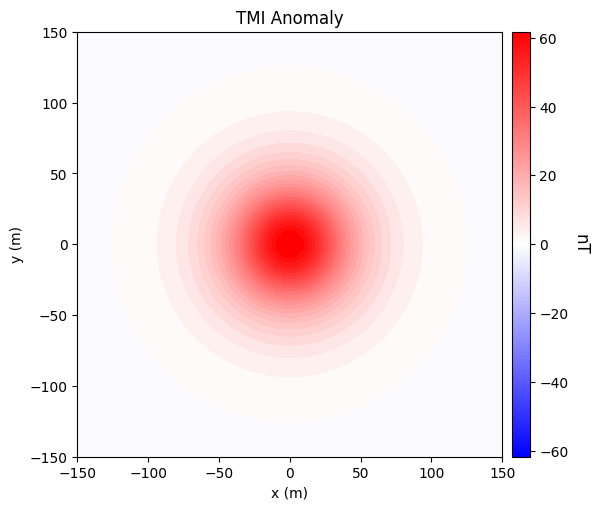

In [4]:
# ---------------------------
xy = receiver_location[:, :2]          # (nObs, 2)
data = dpred_nT              # (nObs,)

# ---------------------------
nx, ny = 50, 50 
xlin = np.linspace(xy[:,0].min(), xy[:,0].max(), nx)
ylin = np.linspace(xy[:,1].min(), xy[:,1].max(), ny)
X, Y = np.meshgrid(xlin, ylin)

Z = griddata(xy, data, (X, Y), method="cubic") 
# ---------------------------
vmax = np.nanmax(np.abs(data))

# ---------------------------
fig = plt.figure(figsize=(6, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
cs = ax1.contourf(
    X, Y, Z,
    levels=30,
    cmap="bwr",
    vmin=-vmax,
    vmax=vmax
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_aspect("equal")

# ---------------------------
ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, cmap=mpl.cm.bwr, orientation="vertical"
)
cbar.set_label("nT", rotation=270, labelpad=15, size=12)

plt.show()

In [11]:
x = receiver_location[:, 0]
y = receiver_location[:, 1]
d = dpred_nT

out = np.column_stack((x, y, d))

np.savetxt(
    "TMI_Toy1.csv",
    out,
    delimiter=",",
    header="x,y,dpred_nT",
    comments=""
)